In [172]:
import re

In [226]:
import pandas as pd
import numpy as np

In [227]:
import matplotlib.pyplot as plt

# Read and clean data

In [34]:
data = pd.read_csv('model_data_5_2.csv')

In [87]:
keep = ['Plc.','Jockey','Trainer',\
        'Actual Wt.','Declar. Horse Wt.',\
        'oriental_1','oriental_2','oriental_3',\
        'apple_1','apple_2','apple_3',\
        'pro_1','pro_2','pro_3',\
        'w_h_odd','s_b_odd',\
        'race_id','Class','Length','Going','Course']

In [88]:
# column to keep for modeling
model_data = data[keep]

In [126]:
# percentage of na rows
(model_data.isna().sum(1) > 0).sum() / model_data.shape[0]

0.02324561403508772

In [110]:
yo = model_data[model_data.isna().sum(1) > 0]
wow = model_data[model_data.isna().sum(1) == 0]

In [130]:
# all na rows has no Plc, so no result
yo['Plc.'].unique()

array(['WV', 'WX', nan, 'WX-A', 'WV-A', 'WXNR'], dtype=object)

In [134]:
# drop all NA, since they anyway have no result
model_data_rna = model_data.dropna().reset_index(drop=True)

In [154]:
model_data_rna['Plc.'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '3 DH', '5 DH', '2 DH', '8 DH', '9 DH', 'UR', '7 DH',
       'FE', 'TNP', 'DNF', 'PU', '10 DH', '12 DH', '1 DH', '11 DH',
       '4 DH', '6 DH'], dtype=object)

In [165]:
# rm rows with no result
model_data_rna = model_data_rna[~model_data_rna['Plc.'].isin(['FE','TNP','DNF','PU','UR'])].reset_index(drop=True)

In [170]:
# handle result
model_data_rna['Plc.'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '3 DH', '5 DH', '2 DH', '8 DH', '9 DH', '7 DH',
       '10 DH', '12 DH', '1 DH', '11 DH', '4 DH', '6 DH'], dtype=object)

In [178]:
model_data_rna['Plc.'] = [int(re.sub(r'\s[a-zA-Z]{1,3}$', '', i)) for i in model_data_rna['Plc.']]

## Cat and Cont variables

In [196]:
# categorical data
cat_data = model_data_rna.select_dtypes('object')
cat_data = cat_data[[i for i in list(cat_data) if i not in ['Plc.','race_id']]]

# continuous data
cont_data = model_data_rna.select_dtypes(['float','int'])
cont_data = cont_data[[i for i in list(cont_data) if i != 'Plc.']]

# race id and result
id_ = model_data_rna[['race_id']]
result = model_data_rna['Plc.'].values

# postition result
position = (result <= 3).astype('int')

In [89]:
from sklearn.preprocessing import OneHotEncoder

# Feature importance

## Continuous variables

In [207]:
from sklearn.preprocessing import StandardScaler

In [208]:
X = StandardScaler().fit_transform(cont_data)

In [211]:
from sklearn.linear_model import LogisticRegression

In [215]:
clf = LogisticRegression(random_state=0, penalty='l1', solver='saga').fit(X, position)

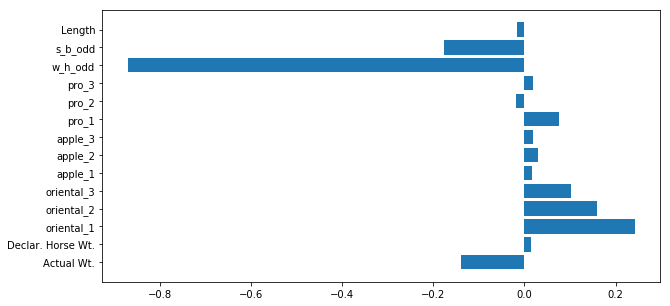

In [230]:
plt.figure(figsize=(10,5))
plt.barh(list(cont_data), clf.coef_[0])
plt.show()

In [259]:
clf.coef_

array([[-0.13868551,  0.01396611,  0.24210445,  0.15905422,  0.10150793,
         0.01554697,  0.03073563,  0.01838924,  0.07585964, -0.01922969,
         0.01937439, -0.8706353 , -0.17615257, -0.01586758]])

## Categorical variables

In [231]:
from sklearn.feature_selection import chi2

In [239]:
def map_cat_to_num(in_arr):
    unique = np.unique(in_arr)
    mapper = {j:i for i,j in enumerate(unique)}
    return np.array([mapper[i] for i in in_arr])

In [241]:
cat_data.head()

,Jockey,Trainer,Class,Going,Course
0,Z Purton,K L Man,Class 4,GOOD,"TURF - ""C"" Course"
1,J Moreira,J Size,Class 4,GOOD,"TURF - ""C"" Course"
2,O Chavez,A S Cruz,Class 4,GOOD,"TURF - ""C"" Course"
3,U Rispoli,T P Yung,Class 4,GOOD,"TURF - ""C"" Course"
4,K Teetan,D E Ferraris,Class 4,GOOD,"TURF - ""C"" Course"


$p<\alpha$, reject null hypothesis, X and y are associated

In [258]:
for i in list(cat_data):
    bow = map_cat_to_num(cat_data[i]).reshape(-1,1)
    p_value = chi2(bow, position)[1]
    if p_value < 0.05:
        asso = 'associate'
    else:
        asso = 'not associate'
    print(i, round(p_value[0], 4), asso)

Jockey 0.0 associate
Trainer 0.0 associate
Class 0.0421 associate
Going 0.4765 not associate
Course 0.6728 not associate


In [93]:
# enc = OneHotEncoder(handle_unknown='ignore').fit(cat_data)